In [92]:
# Used Car Analysis - Vinod Kasturi

In [93]:
# Load Required Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

In [94]:
df = pd.read_csv("data/vehicles.csv")

In [95]:
# Basic Data Cleaning
# Keep rows with price present and in a realistic range
df = df[df["price"].notnull()]
df = df[(df["price"] > 100) & (df["price"] < 100000)]

In [96]:
# Remove duplicates
df = df.drop_duplicates()

In [97]:
# Cap extreme odometer values
if "odometer" in df.columns:
    df = df[df["odometer"].notnull()]
    df = df[df["odometer"] < 500000]

In [98]:
print(f"Rows after cleaning: {len(df):,}")

Rows after cleaning: 386,313


In [99]:
df = df[df["paint_color"].notna() & (df["paint_color"].str.strip() != "")]

In [100]:
df = df[df["drive"].notna() & (df["drive"].str.strip() != "")]

In [101]:
df = df[df["condition"].notna() & (df["condition"].str.strip() != "")]

In [102]:
df = df[df["cylinders"].notna() & (df["paint_color"].str.strip() != "")]

In [103]:
print(f"Rows after cleaning: {len(df):,}")

Rows after cleaning: 124,964


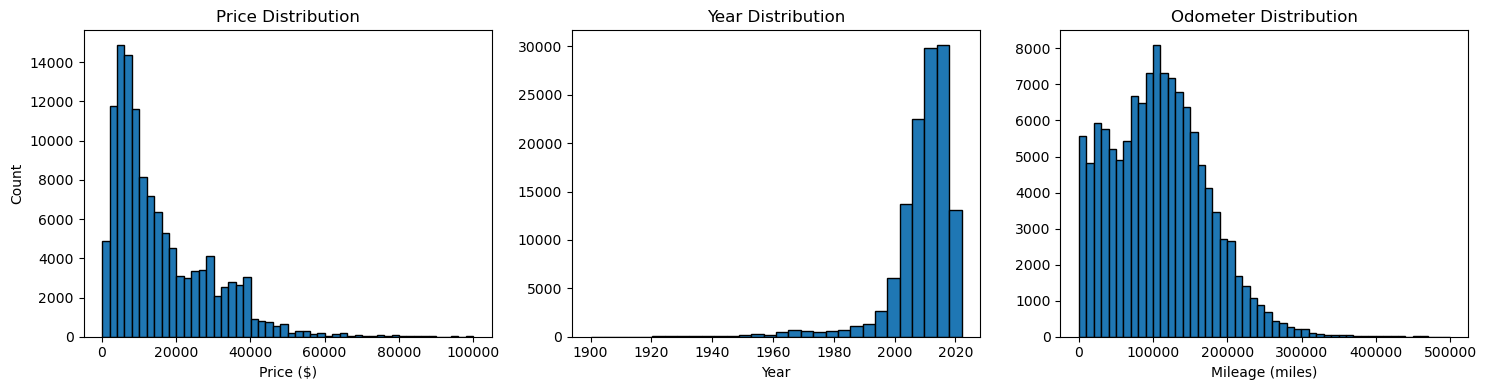

In [104]:
# ===== 2) EDA: distributions =====
plt.figure(figsize=(15,4))

# Price
plt.subplot(1,3,1)
plt.hist(df["price"], bins=50, edgecolor="black")
plt.title("Price Distribution")
plt.xlabel("Price ($)"); plt.ylabel("Count")

# Year
plt.subplot(1,3,2)
plt.hist(df["year"].dropna(), bins=30, edgecolor="black")
plt.title("Year Distribution")
plt.xlabel("Year")

# Odometer
plt.subplot(1,3,3)
plt.hist(df["odometer"].dropna(), bins=50, edgecolor="black")
plt.title("Odometer Distribution")
plt.xlabel("Mileage (miles)")
plt.tight_layout()
plt.show()

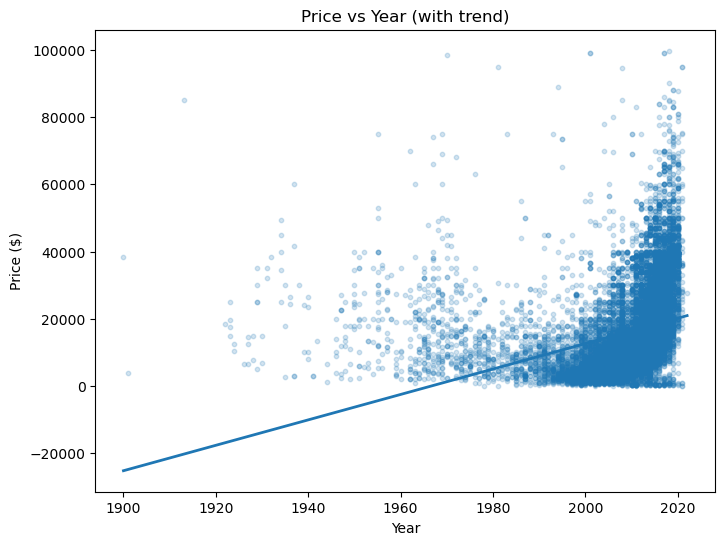

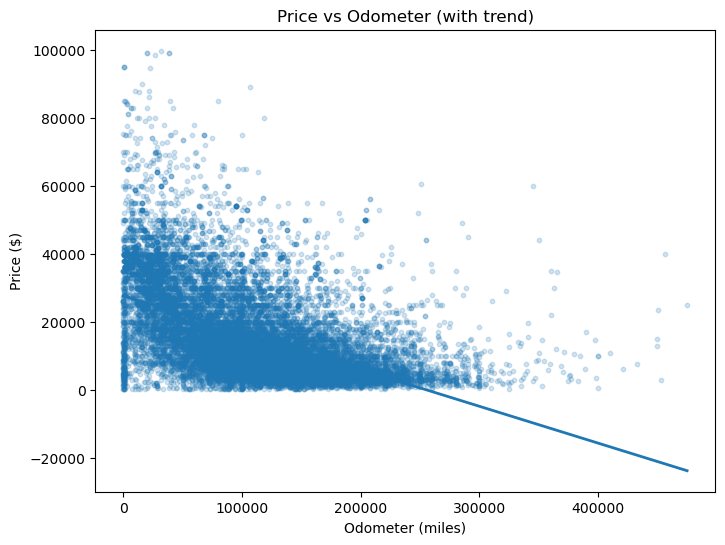

In [105]:
# ===== 3) Relationships: scatter + simple linear trend (polyfit) =====
def scatter_with_trend(x, y, data, title, xlab, ylab, sample_n=20000):
    d = data[[x, y]].dropna()
    if len(d) > sample_n:
        d = d.sample(sample_n, random_state=42)

    # Scatter
    plt.figure(figsize=(8,6))
    plt.scatter(d[x], d[y], alpha=0.2, s=10)

    # Simple linear trend via numpy polyfit
    coeffs = np.polyfit(d[x], d[y], deg=1)
    xline = np.linspace(d[x].min(), d[x].max(), 200)
    yline = coeffs[0]*xline + coeffs[1]
    plt.plot(xline, yline, linewidth=2)

    plt.title(title)
    plt.xlabel(xlab); plt.ylabel(ylab)
    plt.show()

scatter_with_trend(
    x="year", y="price", data=df,
    title="Price vs Year (with trend)", xlab="Year", ylab="Price ($)"
)
scatter_with_trend(
    x="odometer", y="price", data=df,
    title="Price vs Odometer (with trend)", xlab="Odometer (miles)", ylab="Price ($)"
)

In [106]:
#===== 4) Modeling: Linear Regression with One-Hot =====
FEATURES = [
    "year","odometer","manufacturer","condition","cylinders","fuel",
    "title_status","transmission","drive","type","paint_color","state"
]
TARGET = "price"

model_df = df[FEATURES + [TARGET]].dropna(subset=["year","odometer","price"])

# Optional: sample for speed
SAMPLE_N = 30000
if len(model_df) > SAMPLE_N:
    model_df = model_df.sample(SAMPLE_N, random_state=42)

X = model_df[FEATURES]
y = model_df[TARGET]

# Identify categorical vs numeric columns
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

preproc = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", max_categories=20), cat_cols),
    ]
)

lin = Pipeline(steps=[
    ("preprocessor", preproc),
    ("model", LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lin.fit(X_train, y_train)
y_pred = lin.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"R²: {r2:.3f} | MAE: ${mae:,.0f}")


R²: 0.633 | MAE: $5,400


In [107]:
# ===== 5) Coefficients & top drivers =====
ohe = lin.named_steps["preprocessor"].transformers_[1][1]
encoded_cat_names = list(ohe.get_feature_names_out(cat_cols))
feature_names = num_cols + encoded_cat_names

coefs = lin.named_steps["model"].coef_
coef_df = pd.DataFrame({"feature": feature_names, "coefficient": coefs})

In [108]:
# Top positive/negative
top_pos = coef_df.sort_values("coefficient", ascending=False).head(10)
top_neg = coef_df.sort_values("coefficient", ascending=True).head(10)

print("\nTop positive drivers:")
print(top_pos.to_string(index=False))

print("\nTop negative drivers:")
print(top_neg.to_string(index=False))


Top positive drivers:
              feature  coefficient
          fuel_diesel  4590.336930
cylinders_8 cylinders  3739.920500
           type_truck  3204.901997
   transmission_other  2153.503954
            drive_4wd  1774.447578
    paint_color_white  1498.827268
   title_status_clean  1238.934337
          type_pickup  1230.532502
  manufacturer_toyota  1220.668605
            drive_rwd  1211.790359

Top negative drivers:
               feature  coefficient
              fuel_gas -4758.534265
 cylinders_4 cylinders -3397.584663
             drive_fwd -2986.237937
transmission_automatic -2451.813966
            type_sedan -2205.979525
              type_SUV -1909.978673
   manufacturer_nissan  -956.905984
    paint_color_silver  -926.308117
        condition_good  -902.888808
        type_hatchback  -855.662410


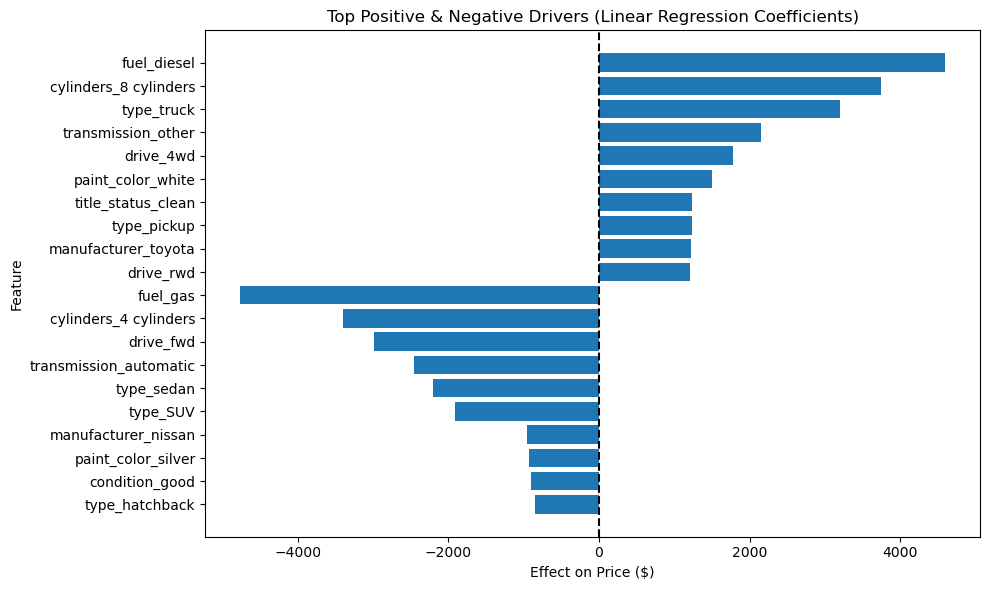

In [109]:
# ===== 6) Quick bar chart of coefficient extremes =====
viz_df = pd.concat([top_pos, top_neg])

plt.figure(figsize=(10,6))
plt.barh(viz_df["feature"], viz_df["coefficient"])
plt.axvline(0, color="black", linestyle="--")
plt.title("Top Positive & Negative Drivers (Linear Regression Coefficients)")
plt.xlabel("Effect on Price ($)")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()